# Computing Differential Privacy budget with PyTorch-DP
## Introduction and inital settings
Our purpose is here to show how to get directly a Differential Privacy budget for a Stochastic Gradient Descent, with a simple handy tool. And then, to link this results to the underlying justifications and finally to show the impact of different parameters on privacy guarantee.

The reader is assumed to have basic knowledge of Deep Learning, Stochastic Gradient Descent (**SGD**) and Differential Privacy (**DP**).


---

*To be run, this notebook is supposed to take place in `pytorch-dp/torchdp/scripts/` directory, see [GitHub of PyTorch-DP](https://github.com/facebookresearch/pytorch-dp/tree/master/) to fetch the code. If not, please adapt the last two `import` statements below.*

*To begin with, please **execute the two following Python cells** to get a correct environment.*

---

In [1]:
# == Usual basics ==
import math
import numpy as np

# == Graphic tools ==
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# To adapt matplotlib graphs to the width of your screen
#  (willingly in a different cell than the next one, see below...)
_DPI = plt.rcParams['figure.dpi']

# == From pytorch-dp, for DP accouting == 

# From pip module if available (not yet, so maybe to be adapted)
#from pytorch_dp import privacy_analysis as tf_privacy
#from pytorch_dp.scripts import compute_dp_sgd_privacy as co

# Or from local files if this notebook is in 
#  pytorch-dp/torchdp/scripts/ ...
import sys
sys.path.append("..")
sys.path.append("../..")
# ...or even without those three uggly lines above, 
#  if the notebook stands in pytorch-dp/torchdp/
import privacy_analysis as tf_privacy
import compute_dp_sgd_privacy as co

In [2]:
# Optional adaptation to your screen (for matplotlib plots)

# (It doesn't take place in the same cell as above, to avoid 
#   cumulating zooms when iterating modifications on _zoom value)

# == Your zoom factor (THE ONLY VALUE TO MODIFY) == 
_zoom = 1.2

# Modify
plt.rcParams['figure.dpi'] = int(_DPI * _zoom)
# Used to restore original zoom value if a crash occurs 
#  in a cell where scale has been modifyed.
dim_memo = plt.rcParams['figure.figsize']

### <span id="toc">↳ Here's the plan</span>
* [A short intro: practical examples of direct privacy budget calculation.](#i)
* [Theorical grounds and PyTorch-DP functions to compute this budget.](#ii)
* [What does DP protection depend on ?](#iii)

--- 
## <span id="i">A short demo to begin with...</span> [⌂](#toc)
---
Let's suppose you want to train a Deep Learning model (network) using **Differential Private Stochastic Gradient Descent**. You have set an acceptable value for $\delta$ (about the $(\varepsilon,\ \delta)$-DP) and then, you want to get the associated best $\varepsilon$ for a given training. As this learning step is quite slow and consumes the privacy budget, it's interesting to estimate it independently, before running it. Let's see how to use PyTorch-DP tools for that purpose. 

Your parameters could be:
* training dataset size = 15000.
* batch size = 250.
* noise multiplier $\sigma$ for Gaussian noise = 1.3. That means if the gradient is clipped so that its $\ell_2$ norm is lesser than $C$, then standard deviation of normal noise added is $C\sigma$ (see in next part).
* number of epochs = 15.
* targetted $\delta$ = $10^{-5}$.

### ↳Pure Python approach
The first possibility consists in calling directly `compute_dp_sgd_privacy()`. *We build this function from the similar one [in TensorFlow-privacy project](https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/analysis/compute_dp_sgd_privacy.py). The associated "RDP order" is mentioned below as "optimal $\alpha$", which is explained later*.

In [15]:
############################################################
#     HERE ARE SOME DEFAULT VALUES FOR THE DP-SGD.         #
# THEY CAN BE MODIFIED, BUT BE AWARE THAT FOLLOWING CELLS  #
#   ARE MAINLY SUPPOSED TO BE EXECUTED SEQUENTIALLY.       #
############################################################
dataset_size, batch_size = 10000, 4
noise_multiplier, epochs, delta = 0.8, 10, 1e-5

In [16]:
my_alphas = [1 + x/10.0 for x in range(1, 100)] + list(range(12, 64))

co.compute_dp_sgd_privacy(dataset_size, 
                          batch_size, 
                          noise_multiplier, 
                          epochs, 
                          delta,
                          alphas=my_alphas
)

# Arguments you may also experiment: 
#  . facultative `printed`, boolean (default True), 
#     to print results, or else just return the (Ɛ, α) tuple.
#  . other values e.g. `alpha=[10, 20, 30]`, 
#     to get noticed in the answer that estimation could be improved.

DP-SGD with
	sampling rate = 0.04% and
	noise_multiplier = 0.8
	iterated over 25000 steps
  satisfies differential privacy with
	Ɛ = 1.47 and
	δ = 1e-05.
  The optimal α is 9.4.


(1.4656133842139047, 9.4)

### ↳As a Shell script

It is also possible to call `compute_dp_sgd_privacy.py` directly __in a shell__, with arguments given on the command line (if necessary, try **`-h`** to get details about them. A default list of $\alpha$ coefficients is provided but could be overwritten).

> *The `!` in first position below allows a shell command execution from the Python notebook. Don't use it in a genuine shell.*

In [17]:
!/usr/bin/env python3 ./compute_dp_sgd_privacy.py -s 15000 -b 4 -n 0.8 -e 10 -d 1e-5

* Script was called with arguments:
	-s = --dataset-size = 15000
	-b = --batch-size = 4
	-n = --noise_multiplier = 0.8
	-e = --epochs = 10
	-d = --delta = 1e-05
	-a = --aplhas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

* Result is:
  DP-SGD with
	sampling rate = 0.0267% and
	noise_multiplier = 0.8
	iterated over 37500 steps


Under the hood, `compute_dp_sgd_privacy()` uses the same tools you could use in your PyTorch model to transform it into a Differential Private one, if its training phase is based on Stochastic Gradient Descent. And then, you are certainly interested in how the previous values are determined, so let's go...

>As far as I know, one of the main reference about privacy with SGD is **"_Deap Learning with Differential Privacy_"** (**Abadi** _et al._, **2016**, **[arXiv:1607.00133](https://arxiv.org/pdf/1607.00133)** _alias_ **[A16]** in the following), see **Algorithm 1** in **section 3.1** for the details about how to clip gradient, then add random noise, to get privacy. 

For his part, **Nicolas Papernot** wrote an easy to read article (on [tensorflow/privacy GitHub](github.com/tensorflow/privacy/tree/master/tutorials/walkthrough)), clearly explaining the vanilla SGD and then how to transform it into a Differentially Private algorithm. His paper's snippets are based on TensorFlow, not PyTorch, but _pytorch-dp_ has roots in _TensorFlow Privacy_ (some portions of code are common), so with the exception of some differences in code extracts, the explanations in this article are still relevant. 

I also love the **[3blue1brown Youtube videos](https://www.youtube.com/watch?v=aircAruvnKk)** about the basics of deep learning. 

*OK that's all about ads :wink: Here are some explanations...*

--- 
## <span id="ii">Let's dive into the magic of Differential Privacy</span> [⌂](#toc)
---
### ↳Rényi DP ~~*vs*~~ serving $(\varepsilon, \delta)$-DP
Indeed, both formalizations of Differential Privacy are involved here: **the result is expressed in $(\varepsilon, \delta)$-DP terms**, which is the *the facto* standard to express DP. In addition, it is quite  understandable (*say, better than more complicated ways of expressing DP* :smile: !).

One could compute the consumption of "privacy budget" for each loop (each application of Gaussian mechanism, i.e. adding normal noise) and could add the $\varepsilon$ relevant values thanks to one of *"(advanced) composition theorems"*. But then, the obtained bound is not tight and the privacy guarantee is too expensive in terms of utility (too much noise has to be added to get it).

That is why a new approach is used *to compute the DP budget*, which allows tigher bounds about the guaranteed  value of $\varepsilon$. It is based on **Rényi-DP of order $\alpha$** (**RDP**), generally expressed in $(\alpha, \varepsilon)$-RDP terms. Note that we write $(\alpha, \varepsilon_\mathbf{\text{rdp}})$-RDP in this notebook, to distinguish the two different $\varepsilon$ coefficients and especially since $\varepsilon_\text{rdp}$ is represented by `rdp` variable in *pytorch-dp*'s code.

But despite many advantages, RDP remains more difficult to interpret, that is why it is *finally translated back into $(\varepsilon, \delta)$-DP terms*. Fortunately, RDP is also compatible with composition:

>In **"*Rényi Differential Privacy*"** (**Mironov** *et al.*, **2017**, **[arXiv:1702.07476](https://arxiv.org/pdf/1702.07476)**) *alias* **[M17]**, **Proposition 1** claims that 

>The composition of a $(\alpha, \varepsilon_{\text{rdp}})$-RDP mechanism and a $(\alpha, \varepsilon'_{\text{rdp}})$-RDP one is $(\alpha, \varepsilon_{\text{rdp}}+\varepsilon'_{\text{rdp}})$-RDP), for any $\alpha>1$.

The idea of the *moments accountant* used to calculate this budget is due to **[A16]**, but it's certainly easier to undestand in **[M17]**, thanks to a new formalization widely spread today. As said before, the RDP privacy budget has to be eventually expressed with $(\varepsilon, \delta)$-DP formalism.
>In **[M17]**, **Proposition 3** claims that

>If a randomized mechanism is $(\alpha, \varepsilon_\text{rdp})$-RDP, then for all $0<\delta<1$ it is also $(\varepsilon, \delta)$-DP where $\varepsilon = \varepsilon_\text{rdp} + \frac{\ln(1/\delta)}{\alpha-1} = \varepsilon_\text{rdp} - \frac{\ln(\delta)}{\alpha-1}$. 

Thereby, we get the needed transformation from $(\alpha, \varepsilon_\text{rdp})$-RDP to $(\varepsilon, \delta)$-DP values. But we still need to know how to get $\varepsilon_\text{rdp}$!

### ↳Computing one $\varepsilon_\text{rdp}$ value



> * **For one single shot** (`q == 1.0` case in code, where `q` denotes the sampling ratio)

>   **Corollary 3** of **Proposition 7** in **[M17]** claims that
>
>   If the $\ell_2$-sensivity of a function $f$ is $1$, then the $\mathbf{G}_{\sigma}\,f$ Gaussian mechanism of $f$ (i.e. addition of a normal noise with a standard deviation $\sigma$ to the image of $f$) is $(\alpha, \varepsilon_\text{rdp})$-RDP for: $\quad\varepsilon_\text{rdp} = \frac{\alpha}{2\sigma^2}$.
>
>  An analog demonstration shows that il $f$ has a $\ell_2$-sensivity of $C$, the same guarantee is provided by adding a noise with $C\sigma$ std. See [this confirmation](https://github.com/facebookresearch/pytorch-dp/issues/11) by Ilya Mironov. That is why $\sigma$ stands for "noise parameter" in this context.

RDP is able to take into account the positive role of sampling about privacy.

> * **With sampling**
>
>   **Theorem 4** and **Corollary 7** of **Theorem 5** in (**"*Rényi Differential Privacy of the Sampled Gaussian Mechanism*"**, **Mironov**, **2019**, **[arXiv:1908.10530](https://arxiv.org/pdf/1908.10530)**) *alias* **[M19]** claims that
>
>   The Sampled Gaussian Mechanism $\mathbf{SGM}_\sigma\, f$ with sample rate $q$ is $(\alpha, \varepsilon_\text{rdp})$-RDP, for all $\varepsilon_\text{rdp} \geqslant A_\alpha$ (*then, the best value for us is* $\varepsilon_\text{rdp} = A_\alpha$), where $A_\alpha$ is a real value depending on $\alpha$ and $q$.
>
>   More precisely (*see* **section 3.3** *of* **[M19]**)
>   * when $\alpha$ is an integer, $A_\alpha = \sum_{k=0}^{\alpha} \binom{\alpha}{k} (1-q)^{\alpha-k} q^k \exp(\frac{k^2-k}{2\sigma^2})$.
>   * when it is fractional, its value is computed by adding the approximations of two convergent series, which is not detailled here. If needed, analyse the code of `_compute_log_a(q, sigma, alpha)` in `torchdp/` directory *(the operations are done in log-arithmetic space, to overcome float numbers representation limits, see the first functions in `privacy_analysis`)...*

If you're interested in the Python coding in Pytorch-DP, have a look at the "internal" function `_compute_rdp()` of `privacy_analysis.py` that calculates $\varepsilon_\text{rdp}$ for one step of the Sampled Gaussian mechanism, from the sampling rate, a given order $\alpha$ and a "noise multiplier". It is the core of the public function `compute_rdp()` (named with no `_` prefix), in which the number of step is indicated.

Here's **an example using Pytorch-DP functions**:

In [18]:
# Sample rate
q = batch_size / dataset_size

# Example of RDP order
alpha = 10

# Number of iterations
steps = 900

# For one step, the "private" function operating under the hood is
ln_A_alpha = tf_privacy._compute_rdp(q, noise_multiplier, alpha)
print(f'With the "private"  _compute_rdp()  function, for α = {alpha}:')
print(f'  ε_rdp = ln(A_α) / (α - 1) = {ln_A_alpha:.4g}.')

# The associated "public" function to be called is
#  . again, for one step
ln_A_alpha = tf_privacy.compute_rdp(q, noise_multiplier, 1, alpha)
print(f'\nAgain, with the public function  compute_rdp() '
      f'we get for a single iteration with α = {alpha}:')
print(f'  ε_rdp = ln(A_α) / (α - 1) = {ln_A_alpha:.4g}.')
#  . or more than one step like in SGM
steps = int(math.ceil(epochs * dataset_size / batch_size))
ln_A_alpha = tf_privacy.compute_rdp(q, noise_multiplier, steps, alpha)
print(f"And for {steps} iterations with α = {alpha},"
      f"\n  ε'_rdp = {steps} ε_rdp = {ln_A_alpha:.4g}. ")

With the "private"  _compute_rdp()  function, for α = 10:
  ε_rdp = ln(A_α) / (α - 1) = 4.398e-05.

Again, with the public function  compute_rdp() we get for a single iteration with α = 10:
  ε_rdp = ln(A_α) / (α - 1) = 4.398e-05.
And for 25000 iterations with α = 10,
  ε'_rdp = 25000 ε_rdp = 1.099. 


### ↳In quest of the optimal $\varepsilon_\text{rdp}$

We won't detail RDP theory here, but remember that a given configuration gets a "budget *curve*", an infinity of $(\alpha, \varepsilon)$ couples that can be seen as coordinates, instead of the *unique* best $\varepsilon$ in $(\varepsilon, \delta)$-DP. 
 
The optimal $\varepsilon_\text{rdp}$ chosen is simply the one mapped with the lowest corresponding $\varepsilon$. The associated RDP order is the "optimal $\alpha$" mentioned in the demo example. There is an infinity of points on the "budget curve", of possible values of $\alpha$. But in practice, testing a well selected list of orders provides good results.

In practice, **`get_privacy_spent()`** of `privacy_analysis` aka `tf_privacy` is dedicated to this task:

In [19]:
# A selection of orders, like the one in `compute_dp_sgd_privacy()`
orders = (
    [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)) 
)

# Compute ε_rdp (`rdp` tensor) for each order
rdp = tf_privacy.compute_rdp(q, noise_multiplier, steps, orders)

# Chose the best, then return its associated ε 
#  in terms of (ε,δ)-DP, and the correspondant order α.
delta = 1e-5
epsilon, optimal_order = tf_privacy.get_privacy_spent(orders, rdp, delta)
print(f'Best guarantee: (ε, δ)-DP = ({epsilon:0.4g}, {delta})-DP,'
      f'obtained with α = {optimal_order} RDP-order.')

Best guarantee: (ε, δ)-DP = (1.466, 1e-05)-DP,obtained with α = 9.4 RDP-order.


### ↳Graphical illustration

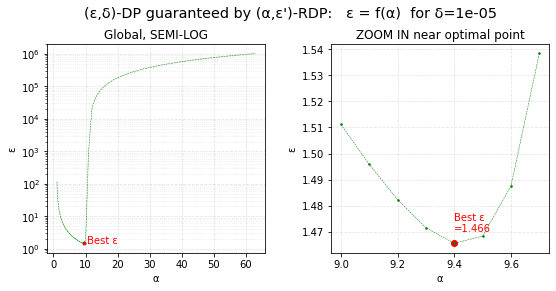

In [20]:
# ===== One ε for each α (`epsilons`, `orders` are tensors) ======
epsilons = np.zeros_like(orders, dtype=float)

for i, alpha in enumerate(orders):
    rdp_eps = tf_privacy.compute_rdp(q, noise_multiplier, steps, alpha) 
    epsilons[i] = rdp_eps - np.log(delta) / (alpha - 1)

# ===== Get the optimal ε index ======
min_index = np.nanargmin(epsilons)   # min ignoring NaN values    
     
# ===== Graphs =====
# *** Wider scale for two graphs ***
local_zoom = np.array([1.5, 1.0])
plt.rcParams['figure.figsize'] = dim_memo * local_zoom

fig = plt.figure()
# Global title separated from subtitles
plt.gcf().subplots_adjust(top = 0.85, wspace=0.3)
fig.suptitle(f"(ε,δ)-DP guaranteed by (α,ε')-RDP:   "
             f"ε = f(α)  for δ={delta}", size='x-large')
ax = fig.add_subplot(121)   # 1 row × 2 col, #1
ax2 = fig.add_subplot(122)

# == Left side, whole view, semi-log ==

ax.semilogy(orders, epsilons, marker='.', markersize=0.1, 
            ls = '--', linewidth=0.5, color='g')
ax.scatter(orders[min_index], epsilons[min_index], marker='.', c='r')
ax.text(orders[min_index], epsilons[min_index],f" Best ε", c="red")

ax.set(title='Global, SEMI-LOG', xlabel='α', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')
ax.grid(color='gray', which='minor', alpha=0.2, ls=':')


# == Right side, closer view ==

# Drawing  ε = f(α)  curve, near arround optimum
a = max(0, min_index - 4)
b = min(len(orders)-1, min_index + 4)

ax2.plot(orders[a:b], epsilons[a:b], marker='.', markersize=3,
         ls = '--', linewidth=0.5, color='g')
ax2.scatter(orders[min_index], epsilons[min_index], marker='o', c='r')
ax2.text(orders[min_index], epsilons[min_index],
         f"Best ε\n={epsilons[min_index]:.4g}\n", color="red")

ax2.set(title='ZOOM IN near optimal point', xlabel='α', ylabel='ε')
ax2.grid(color='gray', alpha=0.2, ls='--')

# *** Restore default dimensions ***
plt.rcParams['figure.figsize'] = dim_memo

--- 
# <span id="iii">What does the privacy guarantee depend on ?</span> [⌂](#toc)
--- 
Let us illustrate the ε-cost dependence on different data and parameters (*one varying, while others kept to default values of the function*).

### ↳Size of the training set
It's not usually a matter of choice. But it's still relevant to confirm that too small datasets make it difficult to guarantee enough privacy.

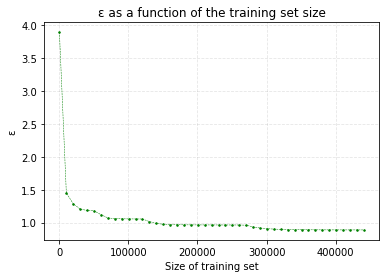

In [30]:
def eps_wrt_size(sz):
    """
    Returns epsilon parameter w.r.t. the `sz` training set size.
    """
    return co.compute_dp_sgd_privacy(sz, 
                                     batch_size, 
                                     noise_multiplier, 
                                     epochs, 
                                     delta, 
                                     alphas=my_alphas,
                                     printed=False
           )[0]

 
# ===== Training set sizes =====
interval = list(range(500, 450_500, 10_000)) 
#interval += list(range(50_500, 500_500, 50_000))

# Computation
sz = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, s in enumerate(interval):
    eps[i] = eps_wrt_size(s)

# Graph
fig, ax = plt.subplots()

ax.plot(sz, eps, marker='.', markersize=3, ls = '--', 
        linewidth=0.5, c='g')

ax.set(title='ε as a function of the training set size', 
       xlabel='Size of training set', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### ↳Batch size
Smaller micro-batches (aka lots, in the Ilya Mironov's terminology) implies more randomness, which is beneficial to privacy. An optimal choice should be a divider of dataset size, to avoid incomplete batch during last round of each epoch.

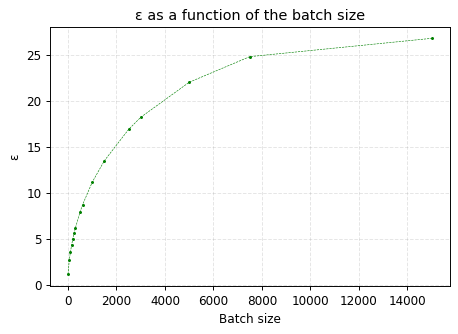

In [10]:
def eps_wrt_batch(bs):
    """
    Returns epsilon parameter w.r.t. the `bs` batch size.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     bs, 
                                     noise_multiplier, 
                                     epochs, 
                                     delta, 
                                     alphas=my_alphas,
                                     printed=False
           )[0]

 
# ===== Batch sizes =====
_interval = list(range(1, 50, 10)) + list(range(50, 500, 50))
_interval += list(range(500, dataset_size+1, 100))
# Keep only dataset_size's dividers
interval = [i for i in _interval if dataset_size % i == 0]

# Computation
bs = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, s in enumerate(interval):
    eps[i] = eps_wrt_batch(s)

# Graph
fig, ax = plt.subplots()

ax.plot(bs, eps, marker='.', markersize=3, ls = '--', 
        linewidth=0.5, color='g')

ax.set(title='ε as a function of the batch size', 
       xlabel='Batch size', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### ↳Noise multiplier $\sigma$
Basically, the more noise is added, the more privacy is protected. But of course, there's a trade off with accuracy, which decreases with noise (this relation depends on your model and your context, it can't be quantified here). 

Let's see how $\varepsilon$ depends on $\sigma$. Above a given threshold, adding noise is not so efficient in terms of privacy.

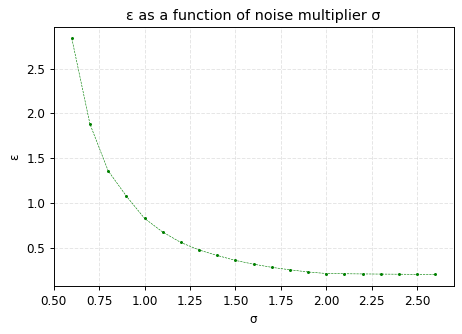

In [11]:
def eps_wrt_sigma(std):
    """
    Returns epsilon parameter w.r.t. the `std` noise multiplier.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     std, 
                                     epochs, 
                                     delta, 
                                     alphas=my_alphas,
                                     printed=False
           )[0]

 
# ===== Noise mutlipliers =====
interval = [0.6 + i/10 for i in range(21)]    

# Computation
std = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, sig in enumerate(interval):
    eps[i] = eps_wrt_sigma(sig)

# Graph
fig, ax = plt.subplots()

ax.plot(std, eps, marker='.', markersize=3, ls = '--', 
        linewidth=0.5, color='g')

ax.set(title='ε as a function of noise multiplier σ', 
       xlabel='σ', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### ↳Number of epochs
Thanks to the tight computation due to RDP, one can verify that the privacy loss increases less than proportionally as a function of the number $n$ of epochs (*seems closer to* $k\sqrt{n}$).

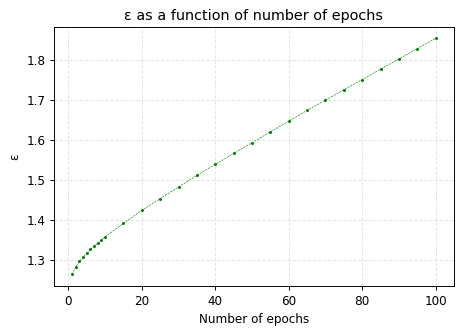

In [12]:
def eps_wrt_epochs(n_epochs):
    """
    Returns epsilon parameter w.r.t. the `n_epochs` number of epochs.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     noise_multiplier, 
                                     n_epochs, 
                                     delta, 
                                     alphas=my_alphas,
                                     printed=False
           )[0]

 
# ===== Numbers of epochs =====
interval = list(range(1,11)) + [i for i in range(15, 101, 5)]    

# Computation
epcs = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, epc in enumerate(epcs):
    eps[i] = eps_wrt_epochs(epc)

# Graph
fig, ax = plt.subplots()

ax.plot(epcs, eps, marker='.', markersize=3, ls = '--', 
        linewidth=0.5, c='g')

ax.set(title='ε as a function of number of epochs', 
       xlabel='Number of epochs', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### ↳Delta
The value of $\delta$ is mainly constraint by the needed level of protection and the dataset size (a value under $\frac{1}{\text{number of epochs}}$ is a serious guarantee). Analyzing how $\varepsilon$ depends on $\delta$ shows that it's important to set it just to a sufficient level, otherwise the overcost could be high if the magnitude of $\delta$ is too low.

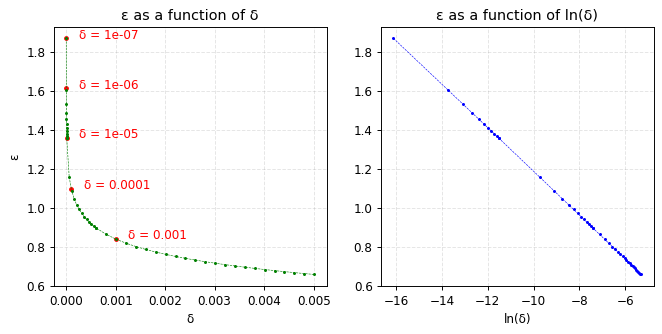

In [13]:
def eps_wrt_delta(d):
    """
    Returns epsilon parameter w.r.t. `d` as delta.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     noise_multiplier, 
                                     epochs, 
                                     d, 
                                     alphas=my_alphas,
                                     printed=False
           )[0]

 
# ===== Deltas =====
interval = ([ i * 1e-7 for i in range(1, 102, 10)] 
            + [ i * 1e-5 for i in range(1, 62, 5)]    
            + [ i * 1e-5 for i in range(61, 502, 20)]    
)

# Computation
deltas = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, d in enumerate(deltas):
    eps[i] = eps_wrt_delta(d)

# Graph

# Wider for two graphs
dim_memo = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'] * np.array([1.5, 1.0])

fig = plt.figure()
#fig, _ = plt.subplots(ncols=2)

ax = fig.add_subplot(121)   # 1 row × 2 col, #1
ax2 = fig.add_subplot(122)

ax.plot(deltas, eps, marker='.', markersize=3, ls = '--', 
        linewidth=0.5, color='g')
ax.set(title='ε as a function of δ', xlabel='δ', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

ax2.plot(np.log(deltas), eps, marker='.', markersize=3, 
         ls = '--', linewidth=0.5, color='b')
ax2.set(title='ε as a function of ln(δ)', xlabel='ln(δ)')
ax2.grid(color='gray', alpha=0.2, ls='--')

# Specific points
h_space = (np.max(deltas) - np.min(deltas))/20
for mag in [m for m in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3] 
                    if np.min(deltas) <= m <= np.max(deltas)]:
    ep = eps_wrt_delta(mag)
    ax.scatter(mag, ep, marker='.', color='r')
    ax.text(mag + h_space , ep, "δ = "+str(mag), color='r')

# Restore default dimensions
plt.rcParams['figure.figsize'] = dim_memo

### ↳Noise multiplier and batch size
The idea is here to compare the impact of both parameters on $\varepsilon$ value.

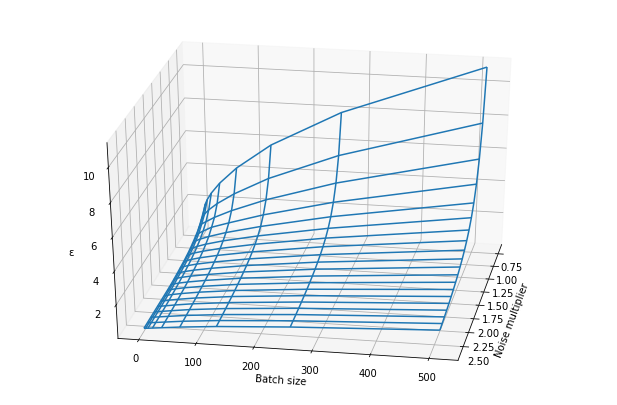

In [14]:
# ===== Noise mutlipliers ===== 
interval = [0.7 + i/10 for i in range(20)]
std = np.array(interval)

# ===== Batch sizes =====
bsz = [1, 4, 8, 16, 32, 64, 128, 256, 512]


# Computing ε

### Tip: set to `already_done = True` to redraw graph 
###      without calculating data again
already_done = False
###
if not already_done:
    eps = np.zeros_like(np.outer(bsz, std)) # Cartesian product
    for x, bs in enumerate(bsz):
        for y, st in enumerate(std):
            eps[x][y] = co.compute_dp_sgd_privacy(dataset_size, 
                                                  int(bs), 
                                                  float(st), 
                                                  epochs, 
                                                  delta, 
                                                  alphas=my_alphas,
                                                  printed=False)[0]

    x, y = np.meshgrid(std, bsz)       

# 3D graph

# Switch mode to add / remove interaction
%matplotlib inline
#%matplotlib ipympl

# Wider scale
local_zoom = np.array([1.8, 1.8])
plt.rcParams['figure.figsize'] = dim_memo * local_zoom

ax = plt.axes(projection='3d')
ax.set(xlabel='Noise multiplier', ylabel="Batch size", zlabel='ε')

# Rotation (degrees)
ax.view_init(30, 10)

surf = ax.plot_wireframe(x, y, eps)
#surf = ax.plot_surface(x, y, eps, linewidth=2, cmap='winter')

# Restore default dimensions
plt.rcParams['figure.figsize'] = dim_memo